In [1]:
import torch
from gnet import GN1D, GN2D
from toep_gmgn import Toep_GMGN1D, Toep_GMGN2D
from dd_gmgn import DD_GMGN1D, DD_GMGN2D
import matplotlib.pyplot as plt

In [2]:
# 1d cases
def kfunc(X,eps=1e-5):
    x = X[:,[0]]
    y = X[:,[1]]
    return -torch.log((x-y).abs() + eps)
def kfunc_(x,eps=1e-5):
    return -torch.log(2*x.abs() + eps)
def ffunc(y):
    return 1-y**2

In [3]:
n = 7
m = 5
k = 1
device = torch.device('cpu')

In [4]:
gnet = GN1D(n, kfunc, device)
fh = ffunc(gnet.grid.x_h).repeat(1,4)
gnet.eval_K()
u_ref = gnet.full_kint(fh)

In [13]:
pts_ds = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(gnet.pts), batch_size=128, shuffle=False)

In [14]:
for pts in pts_ds:
    print(pts[0].shape)

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([1

In [5]:
toep_mg = Toep_GMGN1D(n,m,k,kfunc_,device)
toep_mg.eval_ml_K()
toep_mg.assemble_K()
u_toep = toep_mg.fft_kint(fh)

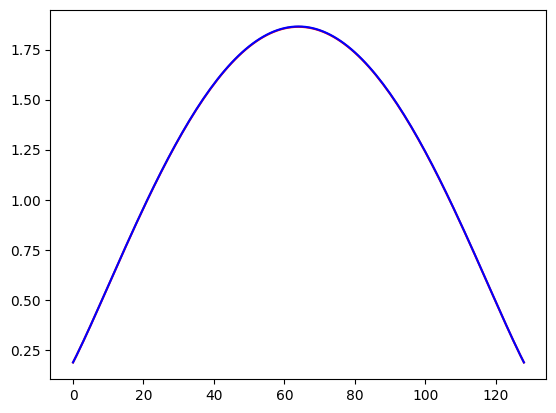

In [7]:
plt.plot(u_ref[:,0], '-r')
plt.plot(u_toep[:,0], '-b')

In [8]:
# 2d cases
def kfunc(X,eps=1e-5):
    x1 = X[:,0]
    y1 = X[:,1]
    x2 = X[:,2]
    y2 = X[:,3]

    K = ((x1-x2)**2 + (y1-y2)**2 + eps)**-0.5    
    return K

def kfunc_(X,eps=1e-5):
    x = X[:,[0]]
    y = X[:,[1]]
    return ((x)**2 + (y)**2 + eps)**-0.5    

def ffunc(X):
    x = X[:,[0]]
    y = X[:,[1]]
    u = 1 - (x**2+y**2)
    u = torch.nan_to_num(u, posinf=0)
    return u

In [9]:
from utils import matrl2_error

In [10]:
n = 7
m = 3
k = 1
device = torch.device('cpu')

In [11]:
gnet = GN2D(n, kfunc, device)
fh = ffunc(gnet.grid.x_h).repeat(1,4)
gnet.eval_K()
u_ref = gnet.full_kint(fh)

In [12]:
# toep_mg 
toep_mg = Toep_GMGN2D(n,m,k,kfunc_,device)
toep_mg.eval_ml_K()
toep_mg.assemble_K()
u_toep = toep_mg.fft_kint(fh)

In [13]:
# dd_mg 
dd_mg = DD_GMGN2D(n,m,k,kfunc,device)
nh = dd_mg.ml_grids[0].nh
dd_mg.restrict_ml_f(fh)
dd_mg.eval_ml_K()
u_dd = dd_mg.ml_kint()

In [14]:
print('dd_mg : {:.3e}'.format(matrl2_error(u_dd, u_ref).numpy()))
print('toep_mg : {:.3e}'.format(matrl2_error(u_toep, u_ref).numpy()))

dd_mg : 1.764e-02
toep_mg : 8.935e-04


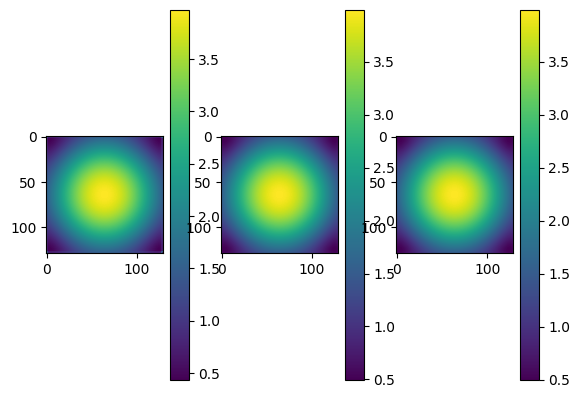

In [15]:
plt.subplot(131)
plt.imshow(u_dd[:,0].reshape(nh, nh))
plt.colorbar()
plt.subplot(132)
plt.imshow(u_toep[:,0].reshape(nh, nh))
plt.colorbar()
plt.subplot(133)
plt.imshow(u_ref[:,0].reshape(nh, nh))
plt.colorbar()
